**Feature Extraction for CHARIS ECG Data**

1. **Import Required Libraries**:  
   Imports `numpy`, `pandas`, `matplotlib`, `csv`, and `os` for handling data processing, analysis, and visualization.

2. **Mount Google Drive**:  
   Mounts Google Drive for accessing stored ECG files if using Google Colab.

3. **Set File Path**:  
   Specifies the directory containing the unprocessed ECG files for the CHARIS dataset.

4. **Initialize Storage Arrays**:  
   Sets up arrays to store metrics for each patient, such as BPM (Beats Per Minute), mean, range, interquartile range (IQR), variance, standard deviation, coefficient of variation (CV), gender, age, classification label, and filename.

5. **Define Patient Demographics and Sampling Information**:  
   Provides each patient’s gender and age, sets the sampling frequency, and calculates the total sampling time in seconds for use in rate-based calculations.

6. **Load ECG Data from Multiple Folders**:  
   Iterates through folders representing individual patients in the CHARIS dataset. For each patient folder, it:
   - Reads all CSV files within the folder, each representing a segment of the ECG recording.
   - Adds the filename as an annotation in each DataFrame.
   - Appends the DataFrames to a list for consolidation.

7. **Concatenate All DataFrames**:  
   Combines all individual ECG data DataFrames from different patients and files into a single DataFrame (`full_df`) for unified data processing and feature extraction.

8. **Calculate and Store Features** (implied for later steps):  
   While not yet calculated here, this script sets up data in a structure suitable for calculating and storing heart rate variability metrics for each patient.

9. **Output**:  
   The final output is a consolidated DataFrame (`full_df`) containing ECG data from all patients, annotated with the file source. This unified DataFrame is contains extracted features, where each record includes patient demographics, ECG signal data, and an identifier for further analysis.

---

This code prepares ECG data for feature extraction by reading and organizing it across multiple files and patients, producing a single DataFrame for analysis. The next steps could involve calculating heart rate metrics and variability indicators on the combined data.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the CSV file into a pandas DataFrame
filepath = '/content/drive/MyDrive/NeuroBeat_GitHub_Repo/Data/Unprocessed/CHARIS/'

In [ ]:
# Create empty arrays to store the results
bpm_arr = []
mean_arr = []
range_arr = []
iqr_arr = []
var_arr = []
std_arr = []
cv_arr = []
gender_arr = []
age_arr = []
classification = []
name = []

In [ ]:
#patient_gender = ['M', 'M', 'M', 'F', 'F', 'M', 'M', 'F', 'F', 'M', 'F', 'M']
patient_gender = [0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0]
patient_age = [19, 25, 74, 44, 21, 20, 73, 45, 56, 43, 55, 60]
sampling_frequency = 50
sampling_time = 100000
sampling_seconds = sampling_time / sampling_frequency

In [ ]:
df_list = []
for i in range(1, 13):
  filefolder = (filepath + "charis" + "%d" + "/") %i
  for filename in os.listdir(filefolder):
    df = pd.read_csv(filefolder + filename)
    df['anno'] = filename
    df_list.append(df)

full_df = pd.concat(df_list)
#full_df
# Calculate the interquartile range (IQR)
full_q1 = np.percentile(full_df['R-R Interval (Samples)'], 25)
full_q3 = np.percentile(full_df['R-R Interval (Samples)'], 75)
full_iqr_rr = full_q3 - full_q1

# Calculate the lower and upper bounds for outliers
full_lower_bound = full_q1 - 1.5 * full_iqr_rr
full_upper_bound = full_q3 + 1.5 * full_iqr_rr

# Remove outliers from the data
full_df_clean = full_df[(full_df['R-R Interval (Samples)'] >= full_lower_bound) & (full_df['R-R Interval (Samples)'] <= full_upper_bound)]
full_data_clean = full_df_clean['R-R Interval (Samples)']
full_data_clean = pd.DataFrame(full_data_clean)


<Axes: >

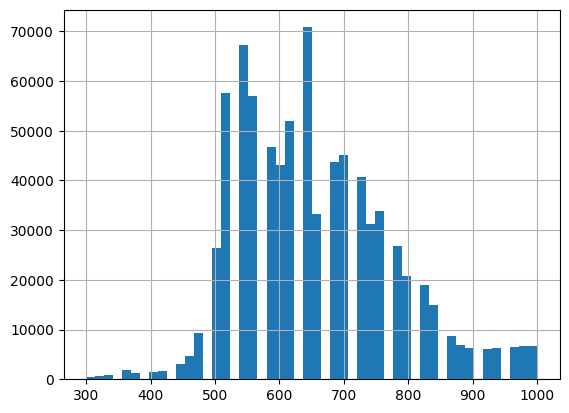

In [ ]:
full_data_clean['R-R Interval (Samples)'].hist(bins=50)

In [ ]:
for i in range(1, 13):
  filefolder = (filepath + "charis" + "%d" + "/") %i

  for filename in os.listdir(filefolder):
    df = pd.read_csv(filefolder + filename)
    peaks = len(df['R-R Interval (Samples)'])

    # Remove outliers from the data
    df_clean = df[(df['R-R Interval (Samples)'] >= full_lower_bound) & (df['R-R Interval (Samples)'] <= full_upper_bound)]
    data_clean = df_clean['R-R Interval (Samples)']
    total = np.sum(data_clean)
    #Average heart rate
    bpm = (peaks/total) *(1000) * (60)
    # Calculate the mean HRV
    mean_rr = np.mean(data_clean)
    # Calculate the range
    range_rr = np.max(data_clean) - np.min(data_clean)
    # Calculate the interquartile range (IQR)
    q1 = np.percentile(data_clean, 25)
    q3 = np.percentile(data_clean, 75)
    iqr_rr = q3 - q1
    # Calculate the variance
    var_rr = np.var(data_clean)
    # Calculate the standard deviation
    std_rr = np.std(data_clean)
    # Calculate the coefficient of variation
    cv_rr = std_rr / np.mean(data_clean) * 100

    bpm_arr.append(bpm)
    mean_arr.append(mean_rr)
    range_arr.append(range_rr)
    iqr_arr.append(iqr_rr)
    var_arr.append(var_rr)
    std_arr.append(std_rr)
    cv_arr.append(cv_rr)
    gender_arr.append(patient_gender[i-1])
    age_arr.append(patient_age[i-1])
    classification.append(1)
    name.append(filename)


In [ ]:

len(bpm_arr)

306

In [ ]:
# set the path to the directory containing the files
new_filepath = '/content/drive/MyDrive/NeuroBeat_GitHub_Repo/Data/Unprocessed/CHARIS/tbi_matrix_2.csv'
# Write the data to the CSV file
combined = list(zip(age_arr, gender_arr, bpm_arr, mean_arr, range_arr, iqr_arr, var_arr, std_arr, cv_arr, classification, name))
with open(new_filepath, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Age', 'Gender', 'BPM', 'Mean', 'Range', 'IQR', 'Variance', 'Std Dev', 'Coeff of Var', 'Classification', 'File'])
    for row in combined:
        writer.writerow(row)

27447.74649665448


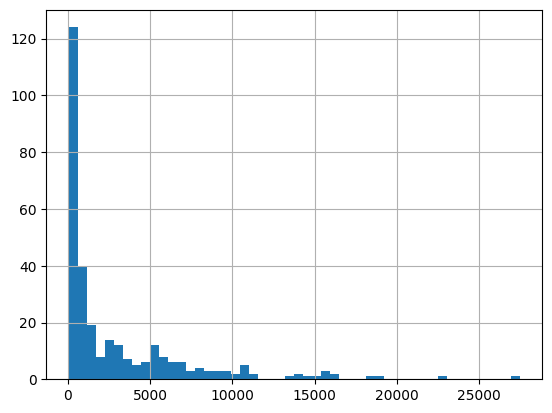

In [ ]:
data = pd.read_csv(new_filepath)
data['Variance'].hist(bins=50)
print(np.max(data['Variance']))

charis1
charis2
charis3
charis4
charis5
charis6
charis7
charis8
charis9
charis10
charis11
charis12


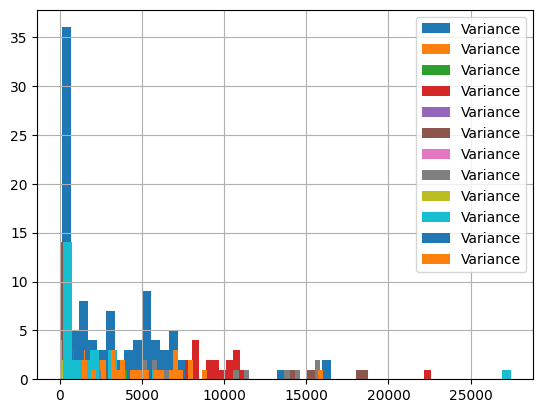

In [ ]:
for i in range(12):
  print('charis'+str(i+1))
  data[data.File.str.contains('charis'+str(i+1))]['Variance'].hist(bins=50, legend = True)

In [ ]:
np.max(data['Variance'])

27447.74649665448

In [ ]:
filename = 'charis13_9_rpeaks_rr_interval.csv'
data = pd.read_csv(filefolder + filename)
print(data)
df = data

      R-Peaks (Sample Index)  R-R Interval (Samples)
0                     800021                   540.0
1                     800047                   520.0
2                     800048                    20.0
3                     800074                   520.0
4                     800100                   520.0
...                      ...                     ...
3783                  899860                   540.0
3784                  899886                   520.0
3785                  899912                   520.0
3786                  899939                   540.0
3787                  899966                   540.0

[3788 rows x 2 columns]


In [ ]:
# Calculate the interquartile range (IQR)
q1 = np.percentile(df['R-R Interval (Samples)'], 25)
print(q1)
q3 = np.percentile(df['R-R Interval (Samples)'], 75)
print(q3)
iqr_rr = q3 - q1
print(iqr_rr)
print(df)

520.0
540.0
20.0
      R-Peaks (Sample Index)  R-R Interval (Samples)
0                     800021                   540.0
1                     800047                   520.0
2                     800048                    20.0
3                     800074                   520.0
4                     800100                   520.0
...                      ...                     ...
3783                  899860                   540.0
3784                  899886                   520.0
3785                  899912                   520.0
3786                  899939                   540.0
3787                  899966                   540.0

[3788 rows x 2 columns]


In [ ]:
# Calculate the lower and upper bounds for outliers
lower_bound = q1 - 1.5 * iqr_rr
upper_bound = q3 + 1.5 * iqr_rr

In [ ]:
# Remove outliers from the data
df_clean = df[(df['R-R Interval (Samples)'] >= lower_bound) & (df['R-R Interval (Samples)'] <= upper_bound)]

In [ ]:
# Print the number of outliers removed
num_outliers = len(df) - len(df_clean)
print(f"Number of outliers removed: {num_outliers}")

Number of outliers removed: 11


In [ ]:
data_clean = df_clean['R-R Interval (Samples)']
print(df_clean)

      R-Peaks (Sample Index)  R-R Interval (Samples)
0                     800021                   540.0
1                     800047                   520.0
3                     800074                   520.0
4                     800100                   520.0
5                     800126                   520.0
...                      ...                     ...
3783                  899860                   540.0
3784                  899886                   520.0
3785                  899912                   520.0
3786                  899939                   540.0
3787                  899966                   540.0

[3777 rows x 2 columns]


In [ ]:
# Calculate the range
range_rr = np.max(data_clean) - np.min(data_clean)
print(range_rr)

40.0


In [ ]:
# Calculate the variance
var_rr = np.var(data_clean)

In [ ]:
# Calculate the standard deviation
std_rr = np.std(data_clean)

In [ ]:
# Calculate the coefficient of variation
cv_rr = std_rr / np.mean(data_clean) * 100

In [ ]:
# Print the results
print(f"Range: {range_rr:.2f}")
print(f"IQR: {iqr_rr:.2f}")
print(f"Variance: {var_rr:.2f}")
print(f"Standard deviation: {std_rr:.2f}")
print(f"Coefficient of variation: {cv_rr:.2f}%")

Range: 40.00
IQR: 20.00
Variance: 97.15
Standard deviation: 9.86
Coefficient of variation: 1.87%


In [ ]:
for filename in os.listdir(filefolder):
  df = pd.read_csv(filefolder + filename)

  # Calculate the interquartile range (IQR)
  q1 = np.percentile(df['R-R Interval (Samples)'], 25)
  q3 = np.percentile(df['R-R Interval (Samples)'], 75)
  iqr_rr = q3 - q1

  # Calculate the lower and upper bounds for outliers
  lower_bound = q1 - 1.5 * iqr_rr
  upper_bound = q3 + 1.5 * iqr_rr

  # Remove outliers from the data
  df_clean = df[(df['R-R Interval (Samples)'] >= lower_bound) & (df['R-R Interval (Samples)'] <= upper_bound)]
  data_clean = df_clean['R-R Interval (Samples)']

  # Calculate the range
  range_rr = np.max(data_clean) - np.min(data_clean)
  # Calculate the interquartile range (IQR)
  q1 = np.percentile(data_clean, 25)
  q3 = np.percentile(data_clean, 75)
  iqr_rr = q3 - q1
  # Calculate the variance
  var_rr = np.var(data_clean)
  # Calculate the standard deviation
  std_rr = np.std(data_clean)
  # Calculate the coefficient of variation
  cv_rr = std_rr / np.mean(data_clean) * 100

  range_arr.append(range_rr)
  iqr_arr.append(iqr_rr)
  var_arr.append(var_rr)
  std_arr.append(std_rr)
  cv_arr.append(cv_rr)
